In [2]:
!pip install deepxde


In [3]:
import deepxde as dde
print(dde.__version__)


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


1.12.2


Compiling model...
'compile' took 0.000180 s

Training model...

0         [9.40e-04, 5.62e-04]    [9.40e-04, 5.62e-04]    []  
10        [2.49e-05, 5.84e-05]    [2.49e-05, 5.84e-05]    []  
20        [1.43e-05, 1.35e-05]    [1.43e-05, 1.35e-05]    []  
30        [3.10e-06, 3.72e-06]    [3.10e-06, 3.72e-06]    []  
40        [2.83e-07, 2.65e-06]    [2.83e-07, 2.65e-06]    []  
50        [4.93e-07, 9.65e-07]    [4.93e-07, 9.65e-07]    []  
60        [1.76e-07, 2.31e-07]    [1.76e-07, 2.31e-07]    []  
70        [1.31e-07, 7.38e-08]    [1.31e-07, 7.38e-08]    []  
80        [8.81e-08, 4.86e-08]    [8.81e-08, 4.86e-08]    []  
90        [6.05e-08, 3.48e-08]    [6.05e-08, 3.48e-08]    []  
100       [4.82e-08, 2.78e-08]    [4.82e-08, 2.78e-08]    []  
110       [4.15e-08, 2.27e-08]    [4.15e-08, 2.27e-08]    []  
120       [3.60e-08, 1.92e-08]    [3.60e-08, 1.92e-08]    []  
130       [3.22e-08, 1.62e-08]    [3.22e-08, 1.62e-08]    []  
140       [2.90e-08, 1.40e-08]    [2.90e-08, 1.40e-08

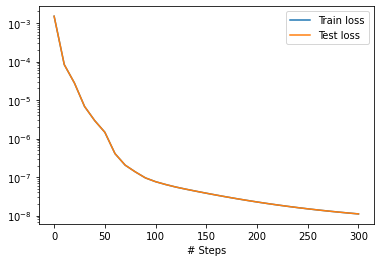

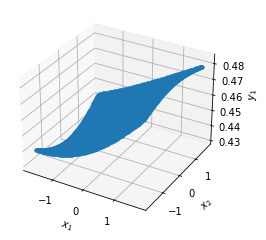

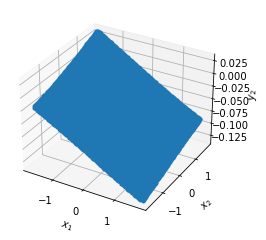

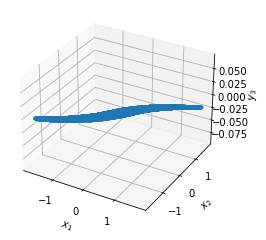

In [15]:
import deepxde as dde
import numpy as np
import torch
from sklearn import preprocessing
import time  # To track elapsed time

# Load and preprocess data
x_disp = np.loadtxt('data_incompressible/m_rose_nu_05/disp_coord')
y_disp = np.loadtxt('data_incompressible/m_rose_nu_05/disp_data')
x_elas = np.loadtxt('data_incompressible/m_rose_nu_05/strain_coord')
y_elas = np.loadtxt('data_incompressible/m_rose_nu_05/m_data')

ss_x = preprocessing.StandardScaler()
x_disp = ss_x.fit_transform(x_disp.reshape(-1, 2))
x_elas = ss_x.fit_transform(x_elas.reshape(-1, 2))

# Define the PDE residuals
def pde(x, u):
    E_learn = u[:, 0:1]
    ux_pred = u[:, 1:2]
    uy_pred = u[:, 2:3]
    
    # Compute derivatives using DeepXDE's automatic differentiation
    ux_x = dde.grad.jacobian(ux_pred, x, i=0, j=0)
    ux_y = dde.grad.jacobian(ux_pred, x, i=0, j=1)
    uy_x = dde.grad.jacobian(uy_pred, x, i=0, j=0)
    uy_y = dde.grad.jacobian(uy_pred, x, i=0, j=1)
    
    # Stress tensor relations using elasticity theory
    sigma_xx = E_learn * (ux_x + 0.3 * uy_y)
    sigma_yy = E_learn * (uy_y + 0.3 * ux_x)
    tau_xy = E_learn * (ux_y + uy_x) / (2 * (1 + 0.3))

    # Residuals for the equilibrium equations (PDEs)
    res_x = dde.grad.jacobian(sigma_xx, x, i=0, j=0) + dde.grad.jacobian(tau_xy, x, i=0, j=1)
    res_y = dde.grad.jacobian(sigma_yy, x, i=0, j=1) + dde.grad.jacobian(tau_xy, x, i=0, j=0)
    return [res_x, res_y]

# Define boundary conditions
def boundary(_, on_boundary):
    return on_boundary

# Data and boundary conditions setup
geom = dde.geometry.Rectangle([x_disp.min(), x_elas.min()], [x_disp.max(), x_elas.max()])

data = dde.data.PDE(
    geom,
    pde,
    [],
    num_domain=5000,
    num_boundary=500,
)

# Define the neural network architecture
layer_size = [2] + [128] * 3 + [3]  # 2 input dimensions, 3 hidden layers, 3 outputs (u, v, E)
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

# Use Softplus activation to ensure non-negative outputs for E_pred
def modify_output(inputs, outputs):
    E_pred = torch.nn.functional.softplus(outputs[:, 0:1])  # Softplus ensures non-negative values for E_pred
    return torch.cat([E_pred, outputs[:, 1:]], axis=1)

net.apply_output_transform(modify_output)

# Custom loss function (no range restriction)
def custom_loss(y_true, y_pred):
    mse_loss = torch.mean((y_true - y_pred[:, 0]) ** 2)  # Standard MSE loss for E_pred
    return mse_loss  # No penalty added

# Convert to a DeepXDE model with PyTorch backend
model = dde.Model(data, net)

# Set the optimizer and compile the model
model.compile("adam", lr=0.001, loss=custom_loss)

# Start the timer to track elapsed time
start_time = time.time()

# Train the model
loss_history, train_state = model.train(iterations=300, display_every=10)

# Predicting values for y_pred_m and y_pred_v after training
# Prediction for elasticity modulus (Young's modulus)
y_pred_m_value = model.predict(x_elas)[:, 0]  # Assuming the modulus is the first output in the prediction
np.savetxt('y_pred_m_final_yuh', y_pred_m_value)

# Prediction for displacement v
y_pred_v_value = model.predict(x_disp)[:, 1]  # Assuming displacement v is the second output in the prediction
np.savetxt('y_pred_v_final_yuh', y_pred_v_value)

# Print elapsed time
print("--- %s Elapsed time ---" % (time.time() - start_time))

# Save training results (loss history and training plots)
dde.saveplot(loss_history, train_state, issave=True, isplot=True)


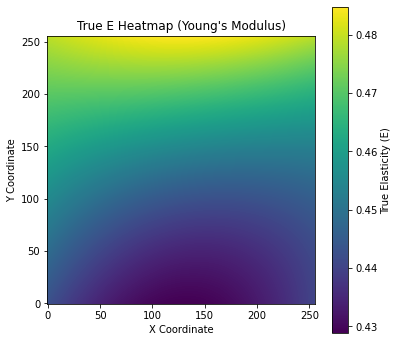

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Load the true E (Young's modulus) values
y_elas = np.loadtxt('y_pred_m_final_yuh')  # Actual Young's modulus (E)

# Reshape the true values to 256x256 (assuming 65536 = 256 * 256)
y_elas_matrix = y_elas.reshape(256, 256)

# Create the heatmap for the true Young's modulus
plt.figure(figsize=(6, 6))
plt.imshow(y_elas_matrix, cmap='viridis', origin='lower')
plt.colorbar(label='True Elasticity (E)')
plt.title('True E Heatmap (Young\'s Modulus)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

Compiling model...
'compile' took 0.000684 s

Training model...

0         [4.97e-04, 6.78e-04]    [4.97e-04, 6.78e-04]    []  
10        [4.97e-05, 2.73e-05]    [4.97e-05, 2.73e-05]    []  
20        [5.05e-06, 3.44e-06]    [5.05e-06, 3.44e-06]    []  
30        [1.34e-06, 1.17e-06]    [1.34e-06, 1.17e-06]    []  
40        [7.05e-07, 1.13e-06]    [7.05e-07, 1.13e-06]    []  
50        [2.94e-07, 7.37e-07]    [2.94e-07, 7.37e-07]    []  
60        [2.11e-07, 4.21e-07]    [2.11e-07, 4.21e-07]    []  
70        [1.73e-07, 1.74e-07]    [1.73e-07, 1.74e-07]    []  
80        [1.11e-07, 1.07e-07]    [1.11e-07, 1.07e-07]    []  
90        [8.69e-08, 7.06e-08]    [8.69e-08, 7.06e-08]    []  
100       [6.84e-08, 5.29e-08]    [6.84e-08, 5.29e-08]    []  
110       [5.71e-08, 4.22e-08]    [5.71e-08, 4.22e-08]    []  
120       [4.78e-08, 3.49e-08]    [4.78e-08, 3.49e-08]    []  
130       [4.06e-08, 2.92e-08]    [4.06e-08, 2.92e-08]    []  
140       [3.49e-08, 2.45e-08]    [3.49e-08, 2.45e-08

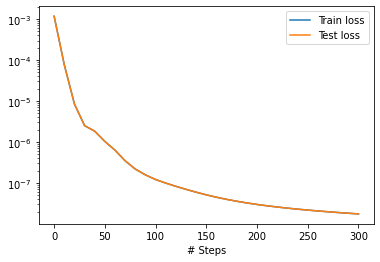

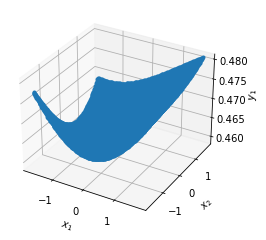

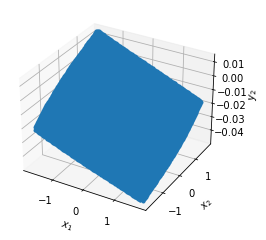

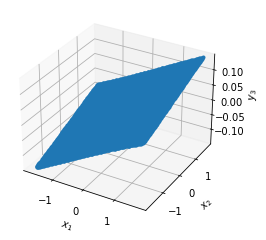

In [18]:
import deepxde as dde
import numpy as np
import torch
from sklearn import preprocessing
import time  # To track elapsed time

# Load and preprocess data
x_disp = np.loadtxt('data_incompressible/m_rose_nu_05/disp_coord')
y_disp = np.loadtxt('data_incompressible/m_rose_nu_05/disp_data')
x_elas = np.loadtxt('data_incompressible/m_rose_nu_05/strain_coord')
y_elas = np.loadtxt('data_incompressible/m_rose_nu_05/m_data')

ss_x = preprocessing.StandardScaler()
x_disp = ss_x.fit_transform(x_disp.reshape(-1, 2))
x_elas = ss_x.fit_transform(x_elas.reshape(-1, 2))

# Define the PDE residuals
def pde(x, u):
    E_learn = u[:, 0:1]
    ux_pred = u[:, 1:2]
    uy_pred = u[:, 2:3]
    
    # Compute derivatives using DeepXDE's automatic differentiation
    ux_x = dde.grad.jacobian(ux_pred, x, i=0, j=0)
    ux_y = dde.grad.jacobian(ux_pred, x, i=0, j=1)
    uy_x = dde.grad.jacobian(uy_pred, x, i=0, j=0)
    uy_y = dde.grad.jacobian(uy_pred, x, i=0, j=1)
    
    # Stress tensor relations using elasticity theory
    sigma_xx = E_learn * (ux_x + 0.3 * uy_y)
    sigma_yy = E_learn * (uy_y + 0.3 * ux_x)
    tau_xy = E_learn * (ux_y + uy_x) / (2 * (1 + 0.3))

    # Residuals for the equilibrium equations (PDEs)
    res_x = dde.grad.jacobian(sigma_xx, x, i=0, j=0) + dde.grad.jacobian(tau_xy, x, i=0, j=1)
    res_y = dde.grad.jacobian(sigma_yy, x, i=0, j=1) + dde.grad.jacobian(tau_xy, x, i=0, j=0)
    return [res_x, res_y]

# Define boundary conditions
def boundary(_, on_boundary):
    return on_boundary

# Data and boundary conditions setup
geom = dde.geometry.Rectangle([x_disp.min(), x_elas.min()], [x_disp.max(), x_elas.max()])

data = dde.data.PDE(
    geom,
    pde,
    [],
    num_domain=5000,
    num_boundary=500,
)

# Define the neural network architecture
layer_size = [2] + [128] * 3 + [3]  # 2 input dimensions, 3 hidden layers, 3 outputs (u, v, E)
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

# Use Softplus activation to ensure non-negative outputs for E_pred
def modify_output(inputs, outputs):
    E_pred = torch.nn.functional.softplus(outputs[:, 0:1])  # Softplus ensures non-negative values for E_pred
    return torch.cat([E_pred, outputs[:, 1:]], axis=1)

net.apply_output_transform(modify_output)

# Custom loss function (no range restriction, just non-negative E_pred)
def custom_loss(y_true, y_pred):
    mse_loss = torch.mean((y_true - y_pred[:, 0]) ** 2)  # Standard MSE loss for E_pred
    return mse_loss  # No penalty added

# Convert to a DeepXDE model with PyTorch backend
model = dde.Model(data, net)

# Set the optimizer and compile the model
model.compile("adam", lr=0.001, loss=custom_loss)

# Start the timer to track elapsed time
start_time = time.time()

# Train the model
loss_history, train_state = model.train(iterations=300, display_every=10)

# Predicting values for y_pred_m and y_pred_v after training
# Prediction for elasticity modulus (Young's modulus)
y_pred_m_value = model.predict(x_elas)[:, 0]  # Assuming the modulus is the first output in the prediction
np.savetxt('y_pred_m_final_yuh', y_pred_m_value)

# Prediction for displacement v
y_pred_v_value = model.predict(x_disp)[:, 1]  # Assuming displacement v is the second output in the prediction
np.savetxt('y_pred_v_final_yuh', y_pred_v_value)

# Print elapsed time
print("--- %s Elapsed time ---" % (time.time() - start_time))

# Save training results (loss history and training plots)
dde.saveplot(loss_history, train_state, issave=True, isplot=True)


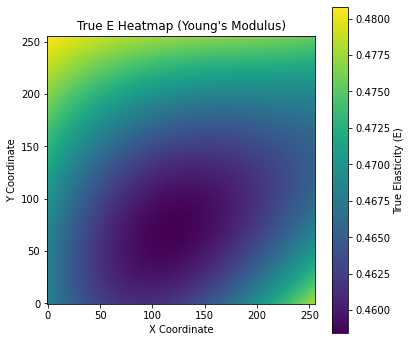

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Load the true E (Young's modulus) values
y_elas = np.loadtxt('y_pred_m_final_yuh')  # Actual Young's modulus (E)

# Reshape the true values to 256x256 (assuming 65536 = 256 * 256)
y_elas_matrix = y_elas.reshape(256, 256)

# Create the heatmap for the true Young's modulus
plt.figure(figsize=(6, 6))
plt.imshow(y_elas_matrix, cmap='viridis', origin='lower')
plt.colorbar(label='True Elasticity (E)')
plt.title('True E Heatmap (Young\'s Modulus)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()